In [2]:
import os
import sys
import pandas as pd

import numpy as np
from numpy import exp
from numpy import log
from numpy import sqrt
from numpy import power

import scipy
from scipy import special

import math
from math import pi
from math import erf
from math import erfc
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
os.getcwd()


import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input,Softmax
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
# from tensorflow.keras.callbacks import EarlyStopping, Callback
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/UOWC")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/UOWC'

In [3]:
class Watertype:
  """
Define the water type and caharacteristics
  Attributes:
    channel_loss:channel loss diffuse coefficient
    Turbulence:
  """
  def __init__(self,channel_loss,Turbulence):
    self.channel_loss = channel_loss
    self.Turbulence = Turbulence
    self.name = ""

In [ ]:
# Genarate data with constant noise
def Simulated_dataset_C(SNR,Z,P,Watertype,Noise='Gauss'):
  """
  This function is used to simulate the input signal to demudulator.
  Args:
    SNR: signl to noise ratios
    Z: channel lenth
    P: transmission power
    Noise:

  Returns:S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal
   the function returns: numrical signal of bit 1 bit 0 , standard divation of bit 1 noise ,bit 0 noise,optimal Threshold

  """
  ######## Receiver SiPM ::MICROFC−SMTPA−30035
  PDE = 0.31 #photo detection efficiency 3mm Sensor 35um - 30035, overvoltage @ 2.5V
  lamda = 420e-9 #Wavelength of Blue light
  A = 0.0058  #SiPM surface area
  G = 3e6#Gain
  pap = 0.002 #probability of afterpulsing
  dCR = 300 #dark count rate6.6*10^6
  Nspad = 4774 #  number of SPAD (microcells)
  td = 82e-9  #  tau_d deadtimex
  P_AP = 1+pap #  probability of current
  pxt = 0.07 # probability of crosstalk
  P_XT = 1 + 0.07 #excess noise factor
  Fe=1.1  # funtion of the doping profile
  RL = 10 #load resistance
  F = P_XT
  ##### constant
  c = 2.25e8 #light speed
  hp = 6.626e-34  # Planck's constant h,
  K_Z = 1.380649e-23 #Boltzmann constant,
  e = 1.6e-19  # Charge of Electron
  Res=PDE*lamda*G*e*P_AP*P_XT/(hp*c)  # SiPM responsitivity
  #  Laser Diode Parameters
  ext=0.33 # extinction ratio
  Ptx1 =(1-ext)*P  #[0.25,0.40,0.5] #  power of bit 1 in watt
  Ptx0=ext*P    # 0.0008   wpower of bit 0 in watt
  ###water characteristics
  ce = Watertype.channel_loss ##channel loss diffuse coefficient
  Lch=math.exp(-ce*Z) # channel loss
  h_L=Lch # channel loss factor

  ### Signal dataset infromation
  Rb = 10e6#[10,30,60]e6 #transmitt data rate
  B=Rb/2 # receiver low-pass filter Bandwidth
  lenth=int(1e5)#  length of the signal and noise
#####total channel gain
  h_gain = h_L #*h_P#*h_T without turbulence without pointing error
#######    noise  ######
  # sgma2_t_n0  = Ptx0/power(10,SNR/10) #variance of the total signal noise for bit 1
  # sgma2_t_n1  = Ptx1/power(10,SNR/10) #variance of the total signal noise for bit 0

  T=300 # equivqlent noise temperature [K]
  Is_1msm1=Res*Ptx1*RL
  Is_0msm0=Res*Ptx0*RL

  I_D = e*G*dCR*(1+pap+pxt)
  sgma2_T = 4*K_Z*T*B*RL
  sgma2_D = 2*e*G*F*B*I_D
  sgma2_s_0 = 2*e*G*F*B*Is_0msm0
  sgma2_s_1 = 2*e*G*F*B*Is_1msm1
  sgma2_t_n0 = sgma2_T +(sgma2_D + sgma2_s_0*h_gain)*(RL**2)
  sgma2_t_n1 = sgma2_T +(sgma2_D + sgma2_s_1*h_gain*1)*(RL**2)
  # print('sgma2_t_n0',sgma2_t_n0,'sgma2_t_n1',sgma2_t_n0)
  #the noise of bit 1 0
  if Noise == "Gauss":
    Noise_0 = np.random.normal(0, np.sqrt(sgma2_s_0*h_gain), lenth)
    Noise_1 = np.random.normal(0, np.sqrt(sgma2_s_1*h_gain), lenth)
  # the noise is Rayleigh noise
  elif Noise == "Rayleigh":
    Noise_0 = np.random.rayleigh(np.sqrt(sgma2_t_n0), lenth)
    Noise_1 = np.random.rayleigh(np.sqrt(sgma2_t_n1), lenth)
  elif Noise == "Uniform":
    Noise_0 = np.random.uniform(-sqrt(sgma2_t_n0),+sqrt(sgma2_s_0),lenth)
    Noise_1 = np.random.uniform(-sqrt(sgma2_t_n1),+sqrt(sgma2_s_1),lenth)
  else:
    print("Please choose noise type: Gauss, Rayleigh, Uniform")
    sys.exit()
####The optical signal received by the SiPM after underwater propagation
  S_R0 = Res*h_gain*Ptx0 + Noise_0 + I_D
  S_R1 = Res*h_gain*Ptx1 + Noise_1 + I_D
####the input signals to the demodulator corresponding to “0” and “1” bits,
  S_0 = RL*S_R0*1e-3 # nurmical simulated current of bit 1
  S_1 = RL*S_R1*1e-3 # nurmical simulated current of bit 0
#
  Denm_trm1 = sqrt(sgma2_t_n1) # standard deviation of bit 1
  Denm_trm0 = sqrt(sgma2_t_n0) # standard deviation of bit 0
#### Here calculate the optimal threshold
  Threshold_optimal = (S_0*sgma2_t_n1  - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ) + ((S_1**2*sgma2_t_n0 )/(sgma2_t_n1 - sgma2_t_n0 ) + ((S_0*sgma2_t_n1
    - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ))**2 - (S_0**2*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 )
     - ((sgma2_t_n0*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 ))*log(sgma2_t_n0 /sgma2_t_n1 ))**0.5
  return S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal


In [14]:
# Generate the dataset base on the channel length and the SNR
def Simulated_dataset_V(SNR,Z,P,Watertype,Noise='Gauss'):
  """
  This function is used to simulate the input signal to demudulator.
  Args:
    SNR: signl to noise ratios
    Z: channel lenth
    P: transmission power
    Noise:

  Returns:S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal
   the function returns: numrical signal of bit 1 bit 0 , standard divation of bit 1 noise ,bit 0 noise,optimal Threshold

  """
  ######## Receiver SiPM ::MICROFC−SMTPA−30035
  PDE = 0.31 #photo detection efficiency 3mm Sensor 35um - 30035, overvoltage @ 2.5V
  lamda = 420e-9 #Wavelength of Blue light
  A = 0.0058  #SiPM surface area
  G = 3e6 #Gain
  pap = 0.002 #probability of afterpulsing
  dCR = 300 #dark count rate6.6*10^6
  c = 2.25e8 #light speed
  hp = 6.626e-34  # Planck's constant h,
  K_Z = 1.380649e-23 #Boltzmann constant,
  e = 1.6e-19  # Charge of Electron
  Nspad = 4774 #  number of SPAD (microcells)
  td = 82e-9  #  tau_d deadtimex
  P_AP = 1+pap #  probability of current
  pxt = 0.07 # probability of crosstalk
  P_XT = 1 + 0.07
  Res=PDE*lamda*G*e*P_AP*P_XT/(hp*c)  # what? SiPM responsitivity
  Fe=1.1  # funtion of the doping profile
  RL = 10 #load resistance
  #  Laser Diode Parameters
  ext=0.33 # extinction ratio
  Ptx1 =(1-ext)*P  #[0.25,0.40,0.5] #  power of bit 1 in watt
  Ptx0=ext*P    # 0.0008   wpower of bit 0 in watt
  ###water characteristics
  ce = Watertype.channel_loss ##channel loss diffuse coefficient
  Lch=math.exp(-ce*Z) # channel loss
  h_L=Lch # channel loss factor
  ### Signal dataset infromation
  Rb = 10e6#[10,30,60]e6 #transmitt data rate
  lenth=int(1e5)#  length of the signal and noise
#####total channel gain
  h_gain = h_L #*h_P#*h_T without turbulence without pointing error
#######    noise  ######
  sgma2_t_n0  = Ptx0/power(10,SNR/10) #variance of the total signal noise for bit 1
  sgma2_t_n1  = Ptx1/power(10,SNR/10) #variance of the total signal noise for bit 0
  #the noise of bit 1 0
  if Noise == "Gauss":
    Noise_0 = np.random.normal(0, np.sqrt(sgma2_t_n0 ), lenth)
    Noise_1 = np.random.normal(0, np.sqrt(sgma2_t_n1 ), lenth)
  # the noise is Rayleigh noise
  elif Noise == "Rayleigh":
    Noise_0 = np.random.rayleigh(np.sqrt(sgma2_t_n0 ), lenth)
    Noise_1 = np.random.rayleigh(np.sqrt(sgma2_t_n1 ), lenth)
  elif Noise == "Uniform":
    Noise_0 = np.random.uniform(-sqrt(sgma2_t_n0 ),+sqrt(sgma2_t_n0 ),lenth)
    Noise_1 = np.random.uniform(-sqrt(sgma2_t_n1 ),+sqrt(sgma2_t_n1 ),lenth)
  else:
    print("Please choose noise type: Gauss, Rayleigh, Uniform")
    sys.exit()
####The optical signal received by the SiPM after underwater propagation
  S_R0 = Res*h_gain*Ptx0 + Noise_0
  S_R1 = Res*h_gain*Ptx1 + Noise_1
####the input signals to the demodulator corresponding to “0” and “1” bits,
  S_0 = RL*S_R0*1e-6# nurmical simulated current of bit 1
  S_1 = RL*S_R1*1e-6# nurmical simulated current of bit 0
#
  Denm_trm1 = sqrt(sgma2_t_n1 ) # standard deviation of bit 1
  Denm_trm0 = sqrt(sgma2_t_n0 ) # standard deviation of bit 0
#### Here calculate the optimal threshold
  Threshold_optimal = (S_0*sgma2_t_n1  - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ) + ((S_1**2*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ) + ((S_0*sgma2_t_n1
    - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ))**2 - (S_0**2*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 )
     - ((sgma2_t_n0 *sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 ))*log(sgma2_t_n0 /sgma2_t_n1 ))**0.5
  return S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal

In [15]:
# Function to create the model
def create_model(input_length):
    model = Sequential()
    model.add(Input(shape=(input_length,)))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile( optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [20]:
class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=512, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.data[batch_indices]
        y = self.labels[batch_indices]
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
# Custom callback to print accuracy with more decimal places
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        print(f"Epoch {epoch+1}: Accuracy = {logs['accuracy']:.15f}, Validation Accuracy = {logs['val_accuracy']:.15f}")

class BERCallback(Callback):
    def __init__(self):
        self.ber_values = []

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        ber = 1 - accuracy
        self.ber_values.append(ber)
        print(f'\nEpoch {epoch + 1}: BER = {ber:.15f}')
# Set up EarlyStopping callback to monitor loss
early_stopping = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='min')


In [33]:
# Define the parameters
SNR = 5
Z = np.linspace(10,30,10)
P = 0.01
clearwater = Watertype(0.551,0)
# clearwater.channel_loss
# early_stopping = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='min')
ber_callback = BERCallback()
# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

Loss = []
Accuracy = []
for z in Z:

  S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal = Simulated_dataset_V(SNR,z,P,clearwater,Noise='Gauss')
  Label0 = np.zeros(len(S_0))
  Label1 = np.ones(len(S_1))
  # File path
  file_path = 'supervised_dataset.csv'
  # Check if the file exists and delete it if it does
  if os.path.exists(file_path):
      os.remove(file_path)
  # Create a DataFrame
  data1 = pd.DataFrame({'Feature': S_1, 'Label': Label1})
  data0 = pd.DataFrame({'Feature': S_0, 'Label': Label0})
  # combine the bit 1 and bit 0 signal
  merged_data = pd.concat([data1, data0], ignore_index=True)
  # Save the dataset to a CSV file
  merged_data.to_csv(file_path, index=False)

  data = pd.read_csv(file_path)
  shuffled_data = shuffle(data)
  # Split the dataset into features (X) and labels (y)
  X = shuffled_data[['Feature']].values
  Y = shuffled_data['Label'].values
  # Split the data into training and testing sets
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  # Create data generators
  batch_size = 512
  training_generator = DataGenerator(X_train, Y_train, batch_size=batch_size)
  validation_generator = DataGenerator(X_test, Y_test, batch_size=batch_size)
  # Adjust input_length to match the number of features
  input_length = X_train.shape[1]

  # Create the model
  CNN0 = create_model(input_length)

  # Train the model using the data generator
  # history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30)
  history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30, callbacks=[reduce_lr, ber_callback, early_stopping, CustomCallback()])
  # Evaluate the model
  loss, accuracy = CNN0.evaluate(validation_generator)

  Loss.append(loss)
  Accuracy.append(accuracy)


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 256)               512       
                                                                 
 batch_normalization_135 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 re_lu_135 (ReLU)            (None, 256)               0         
                                                                 
 dense_181 (Dense)           (None, 96)                24672     
                                                                 
 batch_normalization_136 (B  (None, 96)                384       
 atchNormalization)                                              
                                                                 
 re_lu_136 (ReLU)            (None, 96)              

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

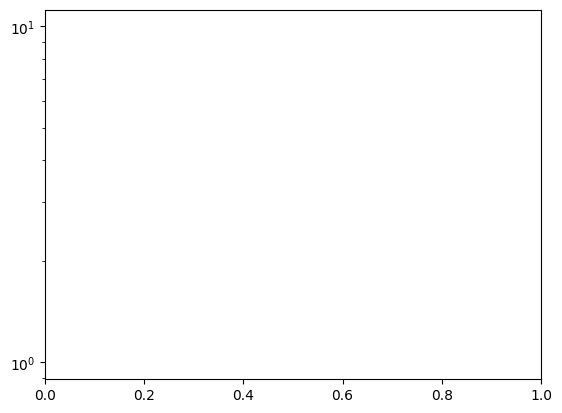

In [32]:
plt.figure
plt.semilogy(Z,Loss)
plt.xlabel("Z")
plt.ylabel("validation Loss")
plt.show()


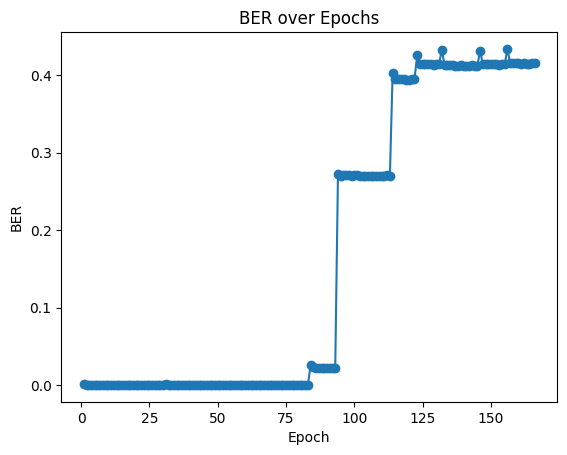

In [27]:
# Visualize the BER values
plt.plot(range(1, len(ber_callback.ber_values) + 1), ber_callback.ber_values, marker='o')
plt.title('BER over Epochs')
plt.xlabel('Epoch')
plt.ylabel('BER')
plt.show()

In [30]:

SNR = np.linspace(0,30,10)
# Z = np.linspace(1,9,9)
Z = 5
P = 0.01
clearwater = Watertype(0.551,0)
Loss = []
Accuracy = []
for snr in SNR:

  S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal = Simulated_dataset_V(snr,Z,P,clearwater,Noise='Gauss')
  Label0 = np.zeros(len(S_0))
  Label1 = np.ones(len(S_1))
  # File path
  file_path = 'supervised_dataset.csv'
  # Check if the file exists and delete it if it does
  if os.path.exists(file_path):
      os.remove(file_path)
  # Create a DataFrame
  data1 = pd.DataFrame({'Feature': S_1, 'Label': Label1})
  data0 = pd.DataFrame({'Feature': S_0, 'Label': Label0})
  # combine the bit 1 and bit 0 signal
  merged_data = pd.concat([data1, data0], ignore_index=True)
  # Save the dataset to a CSV file
  merged_data.to_csv(file_path, index=False)

  data = pd.read_csv(file_path)
  shuffled_data = shuffle(data)
  # Split the dataset into features (X) and labels (y)
  X = shuffled_data[['Feature']].values
  Y = shuffled_data['Label'].values
  # Split the data into training and testing sets
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  # Create data generators
  batch_size = 512
  training_generator = DataGenerator(X_train, Y_train, batch_size=batch_size)
  validation_generator = DataGenerator(X_test, Y_test, batch_size=batch_size)
  # Adjust input_length to match the number of features
  input_length = X_train.shape[1]

  # Create the model
  CNN0 = create_model(input_length)
  # Learning rate scheduler
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
  # Train the model using the data generator
  # history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30)
  history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30, callbacks=[reduce_lr, ber_callback, early_stopping, CustomCallback()])
  # Evaluate the model
  loss, accuracy = CNN0.evaluate(validation_generator)

  Loss.append(loss)
  Accuracy.append(accuracy)

  # print(f'Test Loss: {loss:.6f}')
  # print(f'Test Accuracy: {accuracy:.6f}')




Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 256)               512       
                                                                 
 batch_normalization_105 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 re_lu_105 (ReLU)            (None, 256)               0         
                                                                 
 dense_141 (Dense)           (None, 96)                24672     
                                                                 
 batch_normalization_106 (B  (None, 96)                384       
 atchNormalization)                                              
                                                                 
 re_lu_106 (ReLU)            (None, 96)              

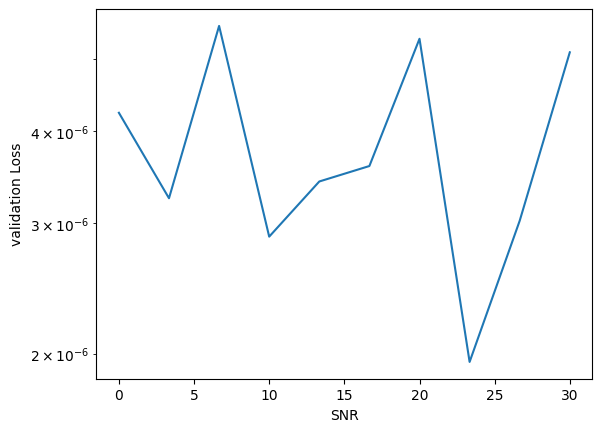

In [31]:
plt.figure
plt.semilogy(SNR,Loss)
plt.xlabel("SNR")
plt.ylabel("validation Loss")
plt.show()

In [ ]:
SNR = np.linspace(0,30,10)
Z = np.linspace(1,9,9)
# Z = 5
P = 0.01
clearwater = Watertype(0.551,0)
# Loss = []
# Accuracy = []
X, Y = np.meshgrid(SNR, Z)
# Create 3D array
Loss = np.zeros_like(X)
Accuracy = np.zeros_like(X)
for j in range(len(Z)):
  for  i in range(len(SNR)):
    S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal = Simulated_dataset(SNR[i],Z[j],P,clearwater,Noise='Gauss')
    Label0 = np.zeros(len(S_0))
    Label1 = np.ones(len(S_1))
    # File path
    file_path = 'supervised_dataset.csv'
    # Check if the file exists and delete it if it does
    if os.path.exists(file_path):
        os.remove(file_path)
    # Create a DataFrame
    data1 = pd.DataFrame({'Feature': S_1, 'Label': Label1})
    data0 = pd.DataFrame({'Feature': S_0, 'Label': Label0})
    # combine the bit 1 and bit 0 signal
    merged_data = pd.concat([data1, data0], ignore_index=True)
    # Save the dataset to a CSV file
    merged_data.to_csv(file_path, index=False)

    data = pd.read_csv(file_path)
    shuffled_data = shuffle(data)
    # Split the dataset into features (X) and labels (y)
    X = shuffled_data[['Feature']].values
    Y = shuffled_data['Label'].values
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Create data generators
    batch_size = 32
    training_generator = DataGenerator(X_train, Y_train, batch_size=batch_size)
    validation_generator = DataGenerator(X_test, Y_test, batch_size=batch_size)
    # Adjust input_length to match the number of features
    input_length = X_train.shape[1]

    # Create the model
    CNN0 = create_model(input_length)
    # Learning rate scheduler
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
    # Train the model using the data generator
    # history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30)
    history = CNN0.fit(training_generator, validation_data=validation_generator, epochs=30, callbacks=[reduce_lr, CustomCallback()])
    # Evaluate the model
    loss, accuracy = CNN0.evaluate(validation_generator)
    Loss[j,i] = loss
    # Loss.append(loss)
    Accuracy[j,i] = accuracy


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(X, Y,Loss,cmap='viridis')
# Set labels
ax.set_xlabel('SNR')
ax.set_ylabel('Z')
ax.set_zlabel('Loss')